In [1]:
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

import os

#Prevent TensorFlow from accessing the GPU (i.e. only use CPU); this must be done before importing TF
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from sutils import *
import numpy as np
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras.applications import inception_v3
from tensorflow.python.keras.models import Model,load_model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing import image

C:\Users\WF4\Anaconda3\envs\tf18_py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
limit_gpu_mem()

In [5]:
data_dir = os.path.join('data', 'dogscats')

In [6]:
batch_size=10
no_of_epochs=5

In [7]:
# Prepare images for training in batches
# NB: They must be in subdirectories named based on their category
batches_train = get_batches(os.path.join(data_dir,'train'), batch_size=batch_size)
batches_val = get_batches(os.path.join(data_dir,'val'), batch_size=batch_size, shuffle=False)
batches_test = get_batches(os.path.join(data_dir,'test'), batch_size=batch_size, shuffle=False)

Found 200 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [8]:
# See how batches.next() works
current_batch = batches_train.next()
batches_train.reset()
print(current_batch)

(array([[[[0.21568629, 0.21960786, 0.16470589],
         [0.2392157 , 0.23137257, 0.18039216],
         [0.25882354, 0.23529413, 0.18823531],
         ...,
         [0.5803922 , 0.56078434, 0.5764706 ],
         [0.5686275 , 0.5529412 , 0.54901963],
         [0.62352943, 0.60784316, 0.6039216 ]],

        [[0.18039216, 0.17254902, 0.1254902 ],
         [0.21176472, 0.19607845, 0.15294118],
         [0.23137257, 0.19607845, 0.16078432],
         ...,
         [0.49411768, 0.47058827, 0.4784314 ],
         [0.53333336, 0.5137255 , 0.5019608 ],
         [0.5686275 , 0.54901963, 0.5372549 ]],

        [[0.18431373, 0.16862746, 0.13333334],
         [0.20000002, 0.17254902, 0.14117648],
         [0.20784315, 0.16470589, 0.14117648],
         ...,
         [0.4039216 , 0.36862746, 0.37254903],
         [0.4901961 , 0.45882356, 0.45098042],
         [0.5176471 , 0.48627454, 0.4784314 ]],

        ...,

        [[0.73333335, 0.67058825, 0.57254905],
         [0.73333335, 0.67058825, 0.57254905

In [9]:
# create the base pre-trained model
#base_model = inception_v3.InceptionV3(weights='imagenet', include_top=True) # pretrained model
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False) # use this to train as last layers are removed

# display the layers of the model
base_model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                      (None, None, None, 32)     864           input_1[0][0]                           
________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalizat (None, None, None, 32)     96            conv2d_1[0][0]                          
________________________________________________________________________________________________________________________
activation_1 (Activation)       

In [10]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# and a softmax layer
predictions = Dense(2, activation='softmax')(x)

In [11]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# display the layers of the model
model.summary(line_length=120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                      (None, None, None, 32)     864           input_1[0][0]                           
________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalizat (None, None, None, 32)     96            conv2d_1[0][0]                          
________________________________________________________________________________________________________________________
activation_1 (Activation)       

In [12]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed0
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
average_pooling2d_2
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_13
batch_normalization_15
batch_normalization_18
batch_normalization_19
activation_13
activation_15
activation_18
activation_19
mixed1
conv2d_23
batch_normalization_23
activat

In [13]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d_1
False
batch_normalization_1
False
activation_1
False
conv2d_2
False
batch_normalization_2
False
activation_2
False
conv2d_3
False
batch_normalization_3
False
activation_3
False
max_pooling2d_1
False
conv2d_4
False
batch_normalization_4
False
activation_4
False
conv2d_5
False
batch_normalization_5
False
activation_5
False
max_pooling2d_2
False
conv2d_9
False
batch_normalization_9
False
activation_9
False
conv2d_7
False
conv2d_10
False
batch_normalization_7
False
batch_normalization_10
False
activation_7
False
activation_10
False
average_pooling2d_1
False
conv2d_6
False
conv2d_8
False
conv2d_11
False
conv2d_12
False
batch_normalization_6
False
batch_normalization_8
False
batch_normalization_11
False
batch_normalization_12
False
activation_6
False
activation_8
False
activation_11
False
activation_12
False
mixed0
False
conv2d_16
False
batch_normalization_16
False
activation_16
False
conv2d_14
False
conv2d_17
False
batch_normalization_14
False
batch_normalization_17
F

In [14]:
# initialize the optimizer
adam = Adam(lr=0.00005)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
%%time
# steps_per_epoch should be (total number of samples in training set/batch_size)
# validation_steps should be (total number of samples in validation set/batch_size)
hist = model.fit_generator(batches_train, steps_per_epoch=len(batches_train), epochs=no_of_epochs, verbose=1,
                validation_data=batches_val, validation_steps=len(batches_val))

Epoch 1/5
20/20 [==============================] - 6s 312ms/step - loss: 0.5374 - acc: 0.7650 - val_loss: 0.2638 - val_acc: 0.9833
Epoch 2/5
20/20 [==============================] - 3s 130ms/step - loss: 0.2967 - acc: 0.9200 - val_loss: 0.1371 - val_acc: 1.0000
Epoch 3/5
20/20 [==============================] - 3s 131ms/step - loss: 0.2091 - acc: 0.9500 - val_loss: 0.1095 - val_acc: 0.9667
Epoch 4/5
20/20 [==============================] - 3s 126ms/step - loss: 0.1887 - acc: 0.9350 - val_loss: 0.0629 - val_acc: 1.0000
Epoch 5/5
20/20 [==============================] - 3s 126ms/step - loss: 0.1690 - acc: 0.9450 - val_loss: 0.0619 - val_acc: 1.0000s: 0.1488 - acc: 0.95
Wall time: 16.9 s


In [16]:
metrics = model.evaluate_generator(batches_test, steps=len(batches_test), max_queue_size=10, workers=1)
print("model accuracy:", metrics[1])

model accuracy: 1.0


In [17]:
model.save(os.path.join('trained-models','cats-dogs.hdf5'))

In [18]:
model = load_model(os.path.join('trained-models','cats-dogs.hdf5'))

In [19]:
def predict_img(model, img_path, img_dim=229):
    img = image.load_img(img_path, target_size=(img_dim, img_dim), interpolation='bilinear')

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = inception_v3.preprocess_input(x)

    print('Input image shape:', x.shape)

    preds = model.predict(x)
    print('Predicted:', preds)
    
    return preds

In [20]:
def dog_or_cat(preds):
    result = np.argmax(preds)
    if result==0:
        print("It's a cat!")
    else:
        print("It's a dog!")

In [21]:
image_dir = os.path.join('data','dogscats','test')

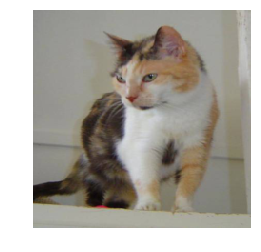

Input image shape: (1, 229, 229, 3)
Predicted: [[9.9966300e-01 3.3703088e-04]]
It's a cat!


In [22]:
img_path = os.path.join(image_dir, 'cat', 'cat.130.jpg')
preds = predict_img(model, img_path)
dog_or_cat(preds)

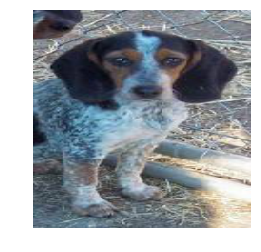

Input image shape: (1, 229, 229, 3)
Predicted: [[0.03898816 0.9610118 ]]
It's a dog!


In [21]:
img_path = os.path.join(image_dir, 'dog', 'dog.130.jpg')
preds = predict_img(model, img_path)
dog_or_cat(preds)

In [23]:
batches_test.reset()
preds = model.predict_generator(batches_test, steps=len(batches_test), max_queue_size=10, workers=1)

In [24]:
preds_labels = np.array(np.where(preds>.5)[1], dtype='float32')
true_labels = np.array([])
batches_test.reset()
for i in range(len(batches_test)):
    current_batch = batches_test.next()
    true_labels = np.append(true_labels, np.array(np.where(current_batch[1]==1)[1], dtype='float32'))

In [25]:
def plot_confusion_matrix(conf_mat, label_names):
    norm_conf = []
    for i in conf_mat:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')
    width, height = conf_mat.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_mat[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=20)

    cb = fig.colorbar(res)
    plt.xticks(range(width), label_names[:width])
    plt.yticks(range(height), label_names[:height])
    plt.xlabel('Predicted Label', size=16)
    plt.ylabel('True Label', size=16)
    plt.show()

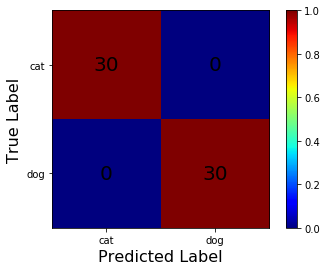

In [26]:
conf_mat = confusion_matrix(true_labels, preds_labels)
plot_confusion_matrix(conf_mat, label_names=['cat','dog'])